# Lesson 4-5: Multi-Agent Patterns

This notebook covers two ways to orchestrate multiple agents:

1. **Handoffs** - Decentralized delegation (agent transfers control to another)
2. **Agents-as-Tools** - Centralized orchestration (manager calls agents as tools)

## The Key Question

When should you use **handoffs** vs **agents-as-tools**?

| Pattern | Control Flow | Best For |
|---------|--------------|----------|
| Handoffs | Transfer control completely | Specialist completes the entire task |
| Agents-as-Tools | Manager stays in control | Combining results from multiple specialists |

## Setup

In [1]:
import nest_asyncio
nest_asyncio.apply()

import os
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

## Part 1: Handoffs (Decentralized Delegation)

A **handoff** transfers the entire conversation to another agent. The new agent:
- Gets the full conversation history
- Takes over completely
- Produces the final response

Think of it like transferring a phone call to a specialist.

In [6]:
from agents import Agent, Runner, enable_verbose_stdout_logging

# Enable verbose logging to visualize execution
enable_verbose_stdout_logging()

# Create specialist agents
math_tutor = Agent(
    name="MathTutor",
    instructions="""You are a math tutor. Help students understand math concepts.
    - Explain step by step
    - Use examples
    - Be encouraging""",
    model="gpt-4.1",
    handoff_description="Hand off for math questions (algebra, calculus, geometry, etc.)"
)

history_tutor = Agent(
    name="HistoryTutor",
    instructions="""You are a history tutor. Help students understand historical events.
    - Provide context and background
    - Discuss causes and effects
    - Make connections to modern times""",
    model="gpt-4.1",
    handoff_description="Hand off for history questions (events, periods, historical figures)"
)

# Create triage agent that routes to specialists
triage_agent = Agent(
    name="TutorTriage",
    instructions="""You are the front desk of a tutoring center.
    Determine what subject the student needs help with and hand off to the appropriate tutor.
    If the question isn't about math or history, politely explain we only offer those subjects.""",
    model="gpt-4.1",
    handoffs=[math_tutor, history_tutor]  # <-- Handoffs go here
)

In [7]:
# Test with a math question
result = await Runner.run(triage_agent, "Can you help me solve 2x + 5 = 13?")
print(result.final_output)

Creating trace Agent workflow with id trace_5c845a68d35641eb8b3bb801f7e71c78
Setting current trace: trace_5c845a68d35641eb8b3bb801f7e71c78
Creating span <agents.tracing.span_data.AgentSpanData object at 0x119df01d0> with id None
Running agent TutorTriage (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11b535270> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.HandoffSpanData object at 0x119c77ed0> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d188e90> with id None
Running agent MathTutor (turn 2)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1094f0> with id None
Calling LLM
LLM responded
Processing output item type=message class=ResponseOutputMessage
Resetting current trace
Absolutely! Let's solve the equation ste

In [8]:
# Test with a history question
result = await Runner.run(triage_agent, "What caused World War I?")
print(result.final_output)

Creating trace Agent workflow with id trace_2fd744f29cb047a89e0e01ba2cfd32b7
Setting current trace: trace_2fd744f29cb047a89e0e01ba2cfd32b7
Creating span <agents.tracing.span_data.AgentSpanData object at 0x119df01d0> with id None
Running agent TutorTriage (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d108780> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.HandoffSpanData object at 0x11b2bf480> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d189430> with id None
Running agent HistoryTutor (turn 2)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1080a0> with id None
Calling LLM
LLM responded
Processing output item type=message class=ResponseOutputMessage
Resetting current trace
**Context and Background:**
World War

In [10]:
# Disable verbose logging before running the test with an unsupported subject

result = await Runner.run(triage_agent, "Can you help me with my chemistry homework?")
print(result.final_output)

Creating trace Agent workflow with id trace_555c8e9e2ddb4292a2adebc2ccf5e26b
Setting current trace: trace_555c8e9e2ddb4292a2adebc2ccf5e26b
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d188b90> with id None
Running agent TutorTriage (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d16d900> with id None
Calling LLM
LLM responded
Processing output item type=message class=ResponseOutputMessage
Resetting current trace
I'm sorry, but we currently only offer tutoring in math and history. If you need help with either of those subjects, I'd be happy to assist!


## Visualizing the Agent Graph

The SDK includes a visualization tool to see agent relationships.

In [11]:
# Note: Requires graphviz to be installed
# pip install openai-agents[viz]
try:
    from agents.extensions.visualization import draw_graph
    draw_graph(triage_agent)
except ImportError:
    print("Install visualization support: pip install openai-agents[viz]")

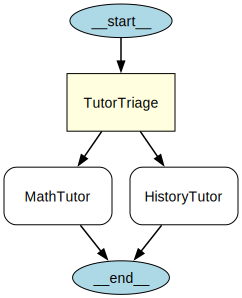

In [12]:
draw_graph(triage_agent)

## How Handoffs Work Under the Hood

When you define `handoffs=[agent1, agent2]`, the SDK:

1. Creates a tool for each agent: `transfer_to_math_tutor`, `transfer_to_history_tutor`
2. Uses `handoff_description` as the tool description
3. When the LLM calls the transfer tool, the new agent takes over
4. The new agent receives the full conversation history

## Part 2: Agents-as-Tools (Centralized Orchestration)

With `agent.as_tool()`, you call another agent like a function:
- The manager agent stays in control
- Gets results back from sub-agents
- Can call multiple agents and synthesize results

Think of it like a manager delegating tasks to team members.

In [13]:
# Create specialist agents
summarizer = Agent(
    name="Summarizer",
    instructions="""You summarize text concisely.
    - Extract key points
    - Keep it brief (2-3 sentences)
    - Maintain accuracy""",
    model="gpt-4.1"
)

fact_checker = Agent(
    name="FactChecker",
    instructions="""You verify factual claims.
    - Identify factual statements
    - Note any potential issues or inaccuracies
    - Be skeptical but fair""",
    model="gpt-4.1"
)

# Create a manager that uses agents as tools
research_manager = Agent(
    name="ResearchManager",
    instructions="""You are a research manager. When given content to analyze:
    1. Use the summarizer to get a concise summary
    2. Use the fact_checker to verify claims
    3. Combine both results into a final report""",
    model="gpt-4.1",
    tools=[
        summarizer.as_tool(
            tool_name="summarize",
            tool_description="Summarize the given text concisely"
        ),
        fact_checker.as_tool(
            tool_name="check_facts",
            tool_description="Verify factual claims in the text"
        )
    ]
)

In [14]:
content = """
The Great Wall of China is the longest wall in the world, stretching over 13,000 miles.
It was built entirely during the Ming Dynasty and took only 50 years to complete.
The wall is visible from space with the naked eye. It was primarily built to keep out
Mongolian invaders and features watchtowers every 100 meters.
"""

result = await Runner.run(research_manager, f"Analyze this content:\n{content}")
print(result.final_output)

Creating trace Agent workflow with id trace_c3d9a2b0967c49179bfc1ece3e7b389f
Setting current trace: trace_c3d9a2b0967c49179bfc1ece3e7b389f
Creating span <agents.tracing.span_data.AgentSpanData object at 0x10596bb90> with id None
Running agent ResearchManager (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11b536850> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x11d1ec530> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x11b00b050> with id None
Invoking tool summarize
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d1ecad0> with id None
Running agent Summarizer (turn 1)
Invoking tool check_facts
Creating span <agents.tracing.span_data.AgentSpanData object at 0x

Notice how the manager:
1. Called the summarizer
2. Called the fact checker
3. Combined the results into a coherent report

The manager **stayed in control** throughout - unlike handoffs where control transfers completely.

## Decision Framework: Handoffs vs Agents-as-Tools

### Use Handoffs When:
- The specialist should **complete the entire task**
- User should **interact directly** with the specialist
- No need to **return to the original agent**
- Example: Customer support triage → specialist handles the whole issue

### Use Agents-as-Tools When:
- Manager needs to **coordinate multiple specialists**
- Results need to be **combined or synthesized**
- Manager should **maintain conversation control**
- Example: Research manager combining summaries and fact-checks

In [15]:
# Let's see another agents-as-tools example: parallel analysis

sentiment_analyst = Agent(
    name="SentimentAnalyst",
    instructions="Analyze the sentiment of text. Output: positive, negative, or neutral with brief reasoning.",
    model="gpt-4.1"
)

keyword_extractor = Agent(
    name="KeywordExtractor",
    instructions="Extract the 3-5 most important keywords from the text.",
    model="gpt-4.1"
)

content_analyzer = Agent(
    name="ContentAnalyzer",
    instructions="""Analyze content by:
    1. Getting sentiment analysis
    2. Extracting keywords
    3. Providing a combined analysis report""",
    model="gpt-4.1",
    tools=[
        sentiment_analyst.as_tool(
            tool_name="analyze_sentiment",
            tool_description="Analyze the sentiment of text"
        ),
        keyword_extractor.as_tool(
            tool_name="extract_keywords",
            tool_description="Extract key terms from text"
        )
    ]
)

In [16]:
review = "This product exceeded my expectations! The build quality is fantastic and customer service was incredibly helpful when I had questions."

result = await Runner.run(content_analyzer, f"Analyze this review:\n{review}")
print(result.final_output)

Creating trace Agent workflow with id trace_51d5d852eb0545779d535670f84c04a9
Setting current trace: trace_51d5d852eb0545779d535670f84c04a9
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d188ad0> with id None
Running agent ContentAnalyzer (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1fe8f0> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x11d1ecfb0> with id None
Creating span <agents.tracing.span_data.FunctionSpanData object at 0x10596bb90> with id None
Invoking tool analyze_sentiment
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d1ed490> with id None
Running agent SentimentAnalyst (turn 1)
Invoking tool extract_keywords
Creating span <agents.tracing.span_data.AgentSp

## Combining Both Patterns

You can use handoffs AND agents-as-tools in the same system.

Example: A customer service system where:
- Triage agent **hands off** to specialists (handoff pattern)
- Each specialist **uses tools** for specific subtasks (agents-as-tools)

In [17]:
from agents import function_tool

# Simple tools for the order agent
@function_tool
def lookup_order(order_id: str) -> str:
    """Look up order details by ID."""
    orders = {
        "ORD-001": "Laptop, Status: Shipped, ETA: Tomorrow",
        "ORD-002": "Mouse, Status: Delivered"
    }
    return orders.get(order_id, f"Order {order_id} not found")

# Order specialist with tools
order_agent = Agent(
    name="OrderSpecialist",
    instructions="You help customers with order inquiries. Use the lookup_order tool to find order details.",
    model="gpt-4.1",
    tools=[lookup_order],
    handoff_description="Hand off for order status, shipping, and delivery questions"
)

# General info agent (no special tools needed)
general_agent = Agent(
    name="GeneralInfo",
    instructions="You answer general questions about the company, policies, and products.",
    model="gpt-4.1",
    handoff_description="Hand off for general questions about policies, products, or the company"
)

# Triage routes to specialists
customer_service = Agent(
    name="CustomerService",
    instructions="Route customers to the right specialist based on their question.",
    model="gpt-4.1",
    handoffs=[order_agent, general_agent]
)

In [18]:
# Order question → handoff to order specialist → uses lookup_order tool
result = await Runner.run(customer_service, "Where is my order ORD-001?")
print(result.final_output)

Creating trace Agent workflow with id trace_c4a4217a3c39454ea34a6c522429e7c9
Setting current trace: trace_c4a4217a3c39454ea34a6c522429e7c9
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d188ad0> with id None
Running agent CustomerService (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1fd4f0> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.HandoffSpanData object at 0x11b046e40> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d1edf70> with id None
Running agent OrderSpecialist (turn 2)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1097c0> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.Funct

In [19]:
# General question → handoff to general info agent
result = await Runner.run(customer_service, "What's your return policy?")
print(result.final_output)

Creating trace Agent workflow with id trace_1503822d4630462eb8be71f9ca99459a
Setting current trace: trace_1503822d4630462eb8be71f9ca99459a
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d189310> with id None
Running agent CustomerService (turn 1)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1fd630> with id None
Calling LLM
LLM responded
Processing output item type=function_call class=ResponseFunctionToolCall
Creating span <agents.tracing.span_data.HandoffSpanData object at 0x11d1ff480> with id None
Creating span <agents.tracing.span_data.AgentSpanData object at 0x11d1edf70> with id None
Running agent GeneralInfo (turn 2)
No conversation_id available for request
Creating span <agents.tracing.span_data.ResponseSpanData object at 0x11d1ff3e0> with id None
Calling LLM
LLM responded
Processing output item type=message class=ResponseOutputMessage
Resetting current trace
Our return policy may vary dependi

## Key Takeaways

1. **Handoffs** transfer control completely - specialist takes over
2. **Agents-as-Tools** keep manager in control - manager synthesizes results
3. **`handoff_description`** tells the routing agent when to use each handoff
4. **`agent.as_tool()`** turns any agent into a callable tool
5. **Combine patterns** for complex systems (triage + tools)

### Decision Cheat Sheet

| Question | If Yes → | If No → |
|----------|----------|----------|
| Does the specialist complete the whole task? | Handoff | Agents-as-Tools |
| Need to combine results from multiple agents? | Agents-as-Tools | Handoff |
| Should user interact with specialist directly? | Handoff | Agents-as-Tools |

Next up: **Guardrails, Sessions, and Tracing** - making your agents production-ready.

# BG: Is the RunContextWrapper a tool written in Python? What are the downsides to using that compared to other methods?

# OR: is for the tool-call approach any timeout parameter or this happens event driven?